In [1]:
include("../Engine/Engine.jl")
using .Engine

using StatsBase, DataFrames, CSV
using JSON, Dates
using DataStructures
import PyPlot as plt
import Seaborn as sns

In [2]:
df = load_dataset(COP26)
df = cop_26_dates(df)
df = trust_score(df)
f, _ = all_users()
df = f(df);

In [3]:
df_during = df[df.partition .== "During COP26", :]
df_during = df_during[df_during.action .== "T", :]


users_JDD_during = ["TheDisproof", "AugustEve2012", "drsohailmahmood", "klausammann", "paulinepark", "Daily_Record", "AandNoa", "EnviroEdgeNews", "RojoRurba002", "bdollabills"]
df_JDD_during = df_during[in.(df_during.username, Ref(users_JDD_during)), :]
users_TE_during = ["UNinWashington", "laralogan", "EvanUnoArt", "TKSitis", "chicagomediaX", "edwinhayward", "KaurananSpring", "cspan", "Nosenatorsson1", "bbwlover2019"]
df_TE_during = df_during[in.(df_during.username, Ref(users_TE_during)), :];

In [4]:
datafolder = "/Users/cyrilvallez/Desktop/Thesis/Data/Twitter/COP26_processed"
files = [file for file in readdir(datafolder, join=true) if occursin(".json", file)]


function remap(files, df1, df2)

    to_datetime = x -> DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS")
    df1_full_urls = [[] for i = 1:length(df1[!,1])]
    df2_full_urls = [[] for i = 1:length(df2[!,1])]

    for file in files

        for line in eachline(file)

            dic = JSON.parse(line, null=missing)
            dic["created_at"] = to_datetime(dic["created_at"])

            index1 = findfirst(dic["created_at"] .== df1.created_at)
            if !isnothing(index1)
                if dic["username"] == df1[index1, "username"] && dic["domain"] == df1[index1, "domain"] && dic["sentiment"] == df1[index1, "sentiment"] 
                    df1_full_urls[index1] = dic["urls"]
                end
            end

            index2 = findfirst(dic["created_at"] .== df2.created_at)
            if !isnothing(index2)
                if dic["username"] == df2[index2, "username"] && dic["domain"] == df2[index2, "domain"] && dic["sentiment"] == df2[index2, "sentiment"] 
                    df2_full_urls[index2] = dic["urls"]
                end
            end

        end

    end
                    
    df1.urls = df1_full_urls
    df2.urls = df2_full_urls

    return df1, df2

end


df_JDD_during, df_TE_during = remap(files, df_JDD_during, df_TE_during);

In [5]:
news = CSV.read(PreProcessing.FULL_NEWSGUARD_TABLE, DataFrame, header=1)

function effective_domain_and_urls(df, news_outlet::DataFrame)

    effective_domain = String["0" for i = 1:length(df[!,1])]
    effective_url = String["0" for i = 1:length(df[!,1])]
    
    for (i, domains) in enumerate(df.domain)

        for (j, domain) in enumerate(domains)
            index = findfirst(domain .== news_outlet."domain")
            if !isnothing(index)
                effective_domain[i] = domain
                effective_url[i] = df.urls[i][j]
            end
        end

	end

    df.effective_domain = effective_domain
    df.effective_url = effective_url

    return df

end


function effective_domain(df, news_outlet::DataFrame)

    effective_domain = String["0" for i = 1:length(df[!,1])]
    
    for (i, domains) in enumerate(df.domain)

        for (j, domain) in enumerate(domains)
            index = findfirst(domain .== news_outlet."domain")
            if !isnothing(index)
                effective_domain[i] = domain
            end
        end

	end

    df.effective_domain = effective_domain

    return df

end

df_during = effective_domain(df_during, news)
df_JDD_during = effective_domain_and_urls(df_JDD_during, news)
df_TE_during = effective_domain_and_urls(df_TE_during, news);

In [6]:
domains_JDD = df_JDD_during.effective_domain
domains_TE = df_TE_during.effective_domain

countmap_JDD = countmap(domains_JDD)
countmap_TE = countmap(domains_TE)


urls_JDD = df_JDD_during.effective_url
urls_TE = df_TE_during.effective_url;

51-element Vector{String}:
 "https://www.cbsnews.com/chicago" ⋯ 64 bytes ⋯ "urce=dlvr.it&utm_medium=twitter"
 "https://abc7chicago.com/climate" ⋯ 78 bytes ⋯ "urce=dlvr.it&utm_medium=twitter"
 "https://abc7chicago.com/climate" ⋯ 65 bytes ⋯ "urce=dlvr.it&utm_medium=twitter"
 "https://news.yahoo.com/breitbar" ⋯ 56 bytes ⋯ "=social-sh&soc_trk=tw&tsrc=twtr"
 "https://abc7chicago.com/climate" ⋯ 63 bytes ⋯ "urce=dlvr.it&utm_medium=twitter"
 "https://www.jpost.com/environme" ⋯ 67 bytes ⋯ "sible-climate-conference-683730"
 "https://abc7chicago.com/hawaii-" ⋯ 77 bytes ⋯ "urce=dlvr.it&utm_medium=twitter"
 "https://news.yahoo.com/climate-" ⋯ 73 bytes ⋯ "=social-sh&soc_trk=tw&tsrc=twtr"
 "https://www.thetimes.co.uk/arti" ⋯ 33 bytes ⋯ "king-into-oyster-beds-7frl75vmh"
 "https://abc7chicago.com/cop26-c" ⋯ 80 bytes ⋯ "urce=dlvr.it&utm_medium=twitter"
 "https://www.c-span.org/video/?5" ⋯ 38 bytes ⋯ "e-action-event-cop26-glasgow-uk"
 "https://www.thetimes.co.uk/arti" ⋯ 33 bytes ⋯ "king-into-oyster-beds-

In [60]:
colormap = OrderedDict(
    "msnbc.com" => "tab:green",
    "thegatewaypundit.com" => "tab:orange",
    "zerohedge.com" => "tab:purple",
    "foxnews.com" => "tab:green",
    "breitbart.com" => "tab:orange",
    "globaltimes.cn" => "tab:red",
    "cgtn.com" => "tab:red",
    "beckernews.com" => "tab:green"
)

politicmap = OrderedDict(
    "tab:red" => "China affiliated",
    "tab:orange" => "US far right",
    "tab:purple" => "far right",
    "tab:green" => "other",
)

OrderedDict{String, String} with 4 entries:
  "tab:red"    => "China affiliated"
  "tab:orange" => "US far right"
  "tab:purple" => "far right"
  "tab:green"  => "other"

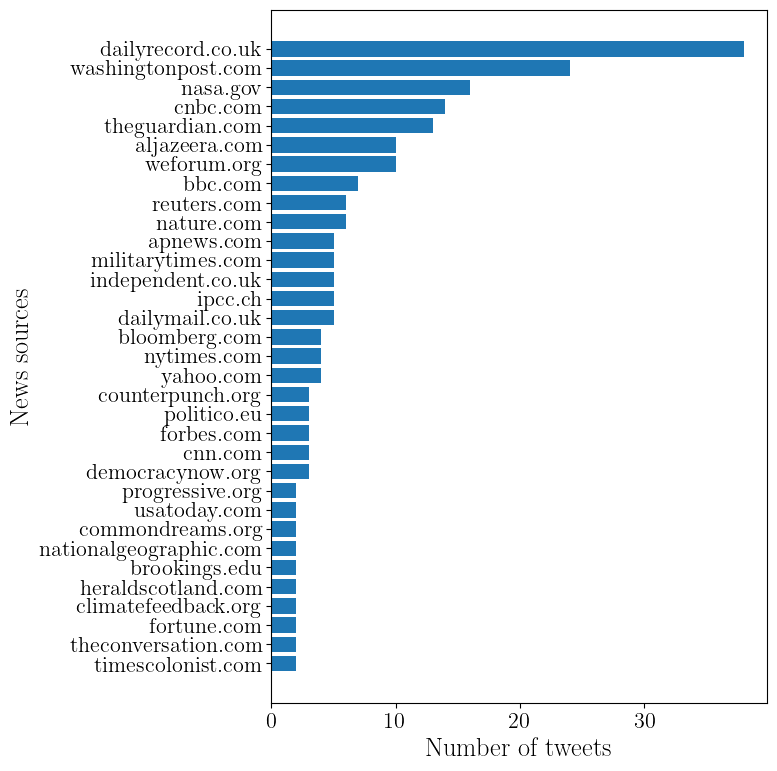

(0.0, 39.9)

In [17]:
# colors_JDD = [colormap[domain] for domain in keys(countmap_JDD)]
# legend_elements = [plt.matplotlib.patches.Patch(facecolor=color, label=politicmap[color]) for color in keys(politicmap) if color in unique(colors_JDD)]


indices = sortperm(collect(values(countmap_JDD)), rev=false)
vals = collect(values(countmap_JDD))[indices]
names = collect(keys(countmap_JDD))[indices]
# colors_JDD = colors_JDD[indices]

indices = vals .> 1
vals = vals[indices]
names = names[indices]

plt.figure(figsize=(6.4, 9))
plt.barh(1:length(vals), vals)
plt.xlabel("Number of tweets")
plt.ylabel("News sources")
# plt.legend(handles=legend_elements, loc="best")
plt.yticks(1:length(vals), names)
lims = plt.xlim()
# plt.savefig("/Users/cyrilvallez/Desktop/Thesis/Figures/news_source_study/JDD_COP_26_during.pdf", bbox_inches="tight");



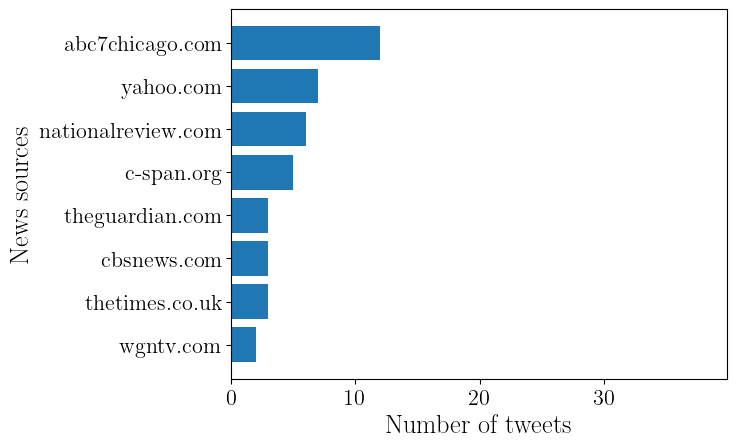

(0.0, 39.9)

In [20]:
# colors_TE = [colormap[domain] for domain in keys(countmap_TE)]
# legend_elements = [plt.matplotlib.patches.Patch(facecolor=color, label=politicmap[color]) for color in keys(politicmap) if color in unique(colors_TE)]


indices = sortperm(collect(values(countmap_TE)), rev=false)
vals = collect(values(countmap_TE))[indices]
names = collect(keys(countmap_TE))[indices]
# colors_TE = colors_TE[indices]

indices = vals .> 1
vals = vals[indices]
names = names[indices]

plt.figure()
plt.barh(1:length(vals), vals)
plt.xlabel("Number of tweets")
plt.ylabel("News sources")
# plt.legend(handles=legend_elements, loc="best")
plt.yticks(1:length(vals), names)
plt.xlim(lims)
# plt.savefig("/Users/cyrilvallez/Desktop/Thesis/Figures/news_source_study/TE_COP_26_during.pdf", bbox_inches="tight");

In [72]:
unique_urls = unique(urls_TE)

print(unique_urls[occursin.("thegatewaypundit", unique_urls)])

["https://www.thegatewaypundit.com/2021/11/biden-insists-surging-gas-prices-caused-green-new-deal-policies-reason-double-green-energy-disastrous-climate-change-speech-video/?utm_source=Twitter&utm_medium=PostTopSharingButtons&utm_campaign=websitesharingbuttons", "https://www.thegatewaypundit.com/2021/11/bidens-build-back-better-includes-2-25-billion-climate-police/?utm_source=Twitter&utm_medium=PostTopSharingButtons&utm_campaign=websitesharingbuttons", "https://www.thegatewaypundit.com/2021/11/lost-exhausted-joe-biden-checks-watch-boris-johnson-concludes-remarks-global-warming-conference/?utm_source=Twitter&utm_medium=PostTopSharingButtons&utm_campaign=websitesharingbuttons", "https://www.thegatewaypundit.com/2021/11/climate-activist-joe-biden-brings-85-car-caravan-talk-threat-global-warming-scotland-video/?utm_source=Twitter&utm_medium=PostTopSharingButtons&utm_campaign=websitesharingbuttons", "https://www.thegatewaypundit.com/2021/10/breaking-archbishop-vigano-chastises-pope-calling-

["https://beckernews.com/watch-biden-falls-asleep-during-the-cop26-climate-change-conference-in-scotland-42846/"]